# The Simple Framework of Choice

Motivated by the combination of simplicity and power in both [Izhikevich's neuron](https://www.izhikevich.org/publications/dsn.pdf) and the [Brian simulator](https://www.frontiersin.org/articles/10.3389/neuro.01.026.2009/full) we take the initiative to build the \textit{simple framework of choice}, an implementation of the simple model of choice with Brian. This framework provides a simple and powerful tool to be used by scientists who wish to conduct a new kind of analysis (e.g. topological, information-theoric, ... ) of a neural network simulation, as their elementary tool.

In [1]:
# Imports
from brian2 import *

## The Simple Model of Choice


### The model as a Brian Object

Here's how the *simple model of choice* can be used as an input for the `NeuronGroup` class.

In [3]:
def dummy_neuron_of_choice():
    # Brian's reset of variable scope which will be used at the beginning of each simulation
    start_scope()

    # Model's dimentionless parameters
    a = 0.03; b = -2; c = -50; d = 100

    # Neuron's biological parameters
    vr = -60; vt = -40; vpeak = 35
    C = 100
    k = 0.7

    # Simulation parameters
    tau = 1*ms

    # The Simple Model of Choice as a Brian Neurongroup object
    model =\
    '''
    dv/dt = (k*(v-vr)*(v-vt) - u)/(C*tau)  : 1 (unless refractory)

    du/dt = a*(b*(v - vr) - u)/tau : 1 (unless refractory)
    '''

    reset =\
    '''
    v = c
    u += d
    '''

    peak_threshold = 'v>vpeak' # Which should not be interpreted as the neuron's membrane threashold, but the reset of neuron when reaching the peak of its spike

    neuron = NeuronGroup(1, model, threshold=peak_threshold, reset=reset, refractory=0*ms, method='euler')
    neuron.v[0] = vr
    
    return neuron

### Simulate the neuron receiving a constant input

We simply add the variable `const_input` to the model.

In [42]:
def simulate_izhikevich_neuron_with_cnst_input():
    # Brian's reset of variable scope which will be used at the beginning of each simulation
    start_scope()

    # Model's dimentionless parameters
    a = 0.03; b = -2; c = -50; d = 100

    # Neuron's biological parameters
    vr = -60; vt = -40; vpeak = 35
    C = 100 
    k = 0.7

    # Simulation's Parameters
    tau = 1*ms; duration = 1000*ms

    # The Simple Model of Choice as a Brian Neurongroup object
    model =\
    '''
    dv/dt = (k*(v-vr)*(v-vt) - u + const_input)/(C*tau)  : 1 (unless refractory)

    du/dt = a*(b*(v - vr) - u)/tau : 1 (unless refractory)

    const_input : 1
    '''

    reset =\
    '''
    v = c
    u += d
    '''

    peak_threshold = 'v>vpeak' # Which should not be interpreted as the neuron's membrane threashold, but the reset of neuron when reaching the peak of its spike

    neuron = NeuronGroup(1, model, threshold=peak_threshold, reset=reset, refractory=0*ms, method='euler')
    neuron.v[0] = vr 


    # The simulation
    statemon = StateMonitor(neuron, ['v', 'const_input'],record=True)
    spikemon = SpikeMonitor(neuron)

    neuron.const_input = 0
    run(0.10*duration)
    neuron.const_input = 70
    run(0.9*duration)
    neuron.const_input = 0
    run(0.15*duration)

    # Plot
    fig, ((ax1), (ax2)) = subplots(2, 1, 'all', gridspec_kw={'height_ratios': [3.2, 0.8], 'hspace': 0.1}, figsize=(7,5))

    ax1.plot(statemon.t/ms, statemon.v[0])
    xlabel('Time (ms)')
    ax1.set_ylabel('v')
    for t in spikemon.t:
        ax1.axvline(t/ms, ls='--', c='C3', lw=1)
        ax1.set_title('Regular-spiking neuron')
    
    input_ylim = (min(statemon.const_input[0])-20, max(statemon.const_input[0])+20) 
    ax2.plot(statemon.t/ms, statemon.const_input[0], c='C1')
    ax2.set_ylim(input_ylim)
    ax2.set_ylabel('I')
    fig.savefig('regular-spiking.png')

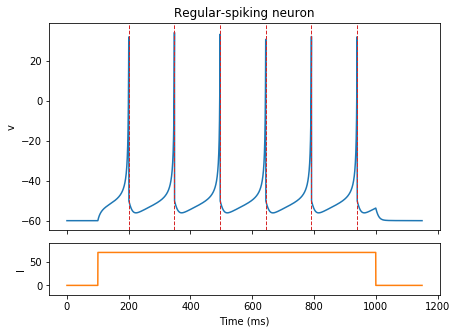

In [43]:
simulate_izhikevich_neuron_with_cnst_input()

### F-I curve comparison

We vary the value of the input received by the neuron and record its spiking frequency.  
We compare Izhikevich's neuron's F-I curve to that of the leaky integrate-and-fire model

#### F-I curve of the Leaky Integrate-and-Fire

In [194]:
def leaky_integrate_and_fire_FI(plotit=True):
    """
        Aadapted from the "Introduction to Brian part 1: Neurons" tutorial in Brian's documentation.
    """
    start_scope()

    N = 90
    tau = 10*ms
    v0_max = 10.
    duration = 1000*ms

    eqs = '''
    dv/dt = (v0-v)/tau : 1 (unless refractory)
    v0 : 1
    '''

    G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
    M = SpikeMonitor(G)

    G.v0 = 'i*v0_max/(N-1)'

    run(duration)
    
    if not plotit:
        return G.v0, M.count/duration
    figure(figsize=(12,4))
    subplot(121)
    plot(M.t/ms, M.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index')
    subplot(122)
    plot(G.v0, M.count/duration)
    xlabel('v0')
    ylabel('Firing rate (sp/s)');
    plot(G.v0[1:] + 0.7, 38*log(G.v0[1:]) + 92)

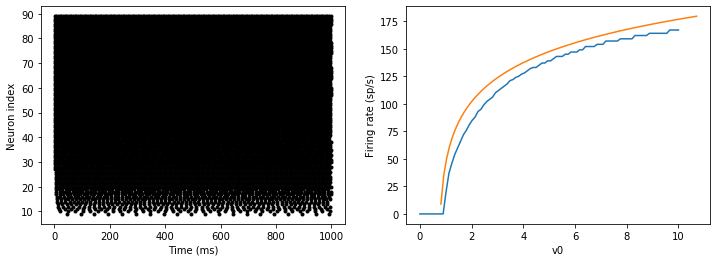

In [195]:
leaky_integrate_and_fire_FI()

#### F-I curve of the simple model of choice

In [252]:
def izhikevich_neuron_FI():
    start_scope()

    # Model's dimentionless parameters
    a = 0.03; b = -2; c = -50; d = 100

    # Neuron's biological parameters
    vr = -60; vt = -40; vpeak = 35
    C = 100 
    k = 0.7

    # Simulation's Parameters
    tau = 1*ms; duration = 800*ms; max_const_input = 1000.

    # The Simple Model of Choice as a Brian Neurongroup object
    model =\
    '''
    dv/dt = (k*(v-vr)*(v-vt) - u + const_input)/(C*tau)  : 1 (unless refractory)

    du/dt = a*(b*(v - vr) - u)/tau : 1 (unless refractory)

    const_input : 1
    '''
    reset =\
    '''
    v = c
    u += d
    '''
    peak_threshold = 'v>vpeak' 

    N = 100 # number of neurons (each having a different cont_input)
    neuron = NeuronGroup(N, model, threshold=peak_threshold, reset=reset, refractory=3*ms, method='euler')
    neuron.v = vr #  + 15*rand()
    neuron.const_input = 'i*max_const_input/(N-1)'

    # Record the spike of each neuron
    spikemon = SpikeMonitor(neuron)
    run(duration)

    # Plot
    figure(figsize=(15,12))

    subplot(222)
    plot(spikemon.t/ms, spikemon.i, '.k', ms=3)
    xlabel('Time (ms)')
    ylabel('Neuron index')

    subplot(223)
    plot(neuron.const_input, spikemon.count/duration, label="firing rate")
    xlabel('const_input')
    ylabel('Firing rate (sp/s)');
    plot(neuron.const_input[5:], 4*sqrt(neuron.const_input[5:])-15, label='square-root')
    legend()
    title("Izhikevich's neuron - F-I curve")
    
    subplot(224)
    input_val, freq = leaky_integrate_and_fire_FI(plotit=False)
    plot(input_val, freq, label='firing rate')
    plot(input_val[1:-6] + 0.7, 38*log(input_val[1:-6]) + 95, label='log')
    legend()
    title('leaky integrate-and-fire - F-I curve')
    
    
    savefig('figures/F-I_curve-comparison')
    

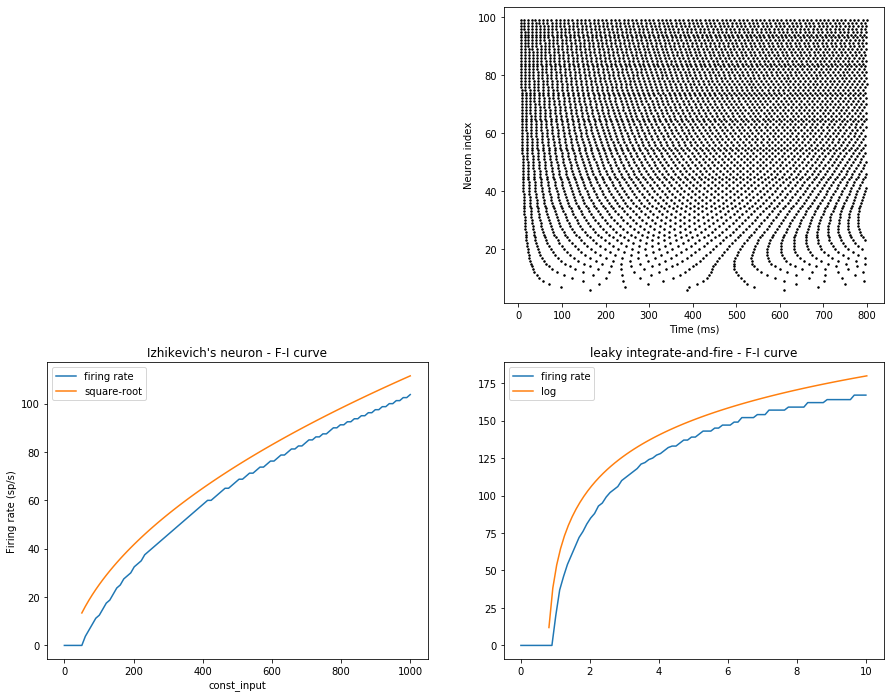

In [251]:
izhikevich_neuron_FI()

## Reproducing Biological neurons

In this section we set the four independent parameters of the simple model of choice to reproduce 16 of the most fundamental neurocompuational properties of biological neurons.

In [4]:
def simulate_izhikevich_neuron_with_variable_input(
    a=0.02, b=0.2, c=-65, d=6, vr=-75, vt=-50, vpeak=30, C=1, k=0.04,
    tau=1*ms, duration=200*ms, v0=None,
    input_func=None, title='tonic spiking'):
    
    start_scope()
    
    if not input_func:
        t_recorded = arange(int(duration/defaultclock.dt))*defaultclock.dt
        input_func = TimedArray(14*sign(t_recorded/ms), dt=defaultclock.dt)
    
    model =\
    '''
    dv/dt = (k*(v-vr)*(v-vt) - u + ext_input)/(C*tau)  : 1 (unless refractory)

    du/dt = a*(b*(v - vr) - u)/tau : 1 (unless refractory)

    ext_input = input_func(t) : 1
    '''
    reset =\
    '''
    v = c
    u += d
    '''
    peak_threshold = 'v>vpeak'
    neuron = NeuronGroup(1, model, threshold=peak_threshold, reset=reset, refractory=0*ms, method='euler')
    neuron.v[0] = v0 if v0 else vr

    statemon = StateMonitor(neuron, ['v', 'ext_input'],record=True)
    spikemon = SpikeMonitor(neuron)
    
    run(duration)

    # Plot
    fig, ((ax1), (ax2)) = plt.subplots(2, 1, 'all', gridspec_kw={'height_ratios': [3.2, 0.8], 'hspace': 0}, figsize=(3,3))

    ax1.plot(statemon.t/ms, statemon.v[0])
    
    for t in spikemon.t:
        ax1.axvline(t/ms, ls='--', c='C3', lw=0.5)
    ax1.axis('off')
    ax1.set_title(title)
    
    input_ylim = (min(statemon.ext_input[0])-5, max(statemon.ext_input[0])+10) 
    ax2.plot(statemon.t/ms, statemon.ext_input[0], c='C1')
    ax2.set_ylim(input_ylim)
    ax2.axis('off')
    
    fig.savefig('figures/'+title+'.png')

In [15]:
def plot_neuro_properties():
    t_recorded = arange(int(1000*ms/defaultclock.dt))*defaultclock.dt
    
    # key : [a, b, c, d, duration_of_simulation, input_function]
    neuron_parameters = {
        'tonic spiking':
            [0.02, 0.2, -65.0, 6.0, 200*ms, TimedArray(14*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'phasic spiking':
            [0.02, 0.25, -65.0, 6.0, 200*ms, TimedArray(9*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'tonic bursting':
            [0.02, 0.2, -50.0, 2.0, 200*ms, TimedArray(15*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'phasic bursting':
            [0.02, 0.25, -55.0, 0.05, 200*ms, TimedArray(9*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'mixed mode':
            [0.02, 0.2, -55.0, 4.0, 200*ms, TimedArray(10*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'spike frequency adaptation':
            [0.01, 0.2, -65.0, 8.0, 200*ms, TimedArray(30*(t_recorded/ms > 20), dt=defaultclock.dt)],
        'Class 1':
            [0.02, -0.1, -55.0, 6.0, 200*ms, TimedArray(0.1*t_recorded/ms, dt=defaultclock.dt)],
        'Class 2': 
            [0.2, 0.26, -65.0, 0.0, 200*ms, TimedArray(0.1*t_recorded/ms, dt=defaultclock.dt) ],
        'resonator':
            [0.1, 0.26, -60.0, -1.0, 400*ms,
                 TimedArray(  11.5*(t_recorded/ms > 10)*(t_recorded/ms < 14)
                            + 11.5*(t_recorded/ms > 30)*(t_recorded/ms < 34)
                            + 11.5*(t_recorded/ms > 100)*(t_recorded/ms < 104)
                            + 11.5*(t_recorded/ms > 180)*(t_recorded/ms < 184), dt=defaultclock.dt)],
        'integrator': 
            [0.02, -0.1, -55.0, 6.0, 200*ms,
                         TimedArray(  16*(t_recorded/ms > 10)*(t_recorded/ms < 12)
                                    + 16*(t_recorded/ms > 15)*(t_recorded/ms < 17)
                                    + 16*(t_recorded/ms > 150)*(t_recorded/ms < 152)
                                    + 16*(t_recorded/ms > 160)*(t_recorded/ms < 162), dt=defaultclock.dt)],
        'rebound spike': 
            [0.03, 0.25, -60.0, 4.0, 200*ms, TimedArray(6 +(-100*(t_recorded/ms > 20)*(t_recorded/ms < 30)), dt=defaultclock.dt)],
        'rebound burst': 
            [0.03, 0.25, -52.0, 0.0, 200*ms, TimedArray(6 +(-100*(t_recorded/ms > 20)*(t_recorded/ms < 30)), dt=defaultclock.dt)],
        'threshold variability': 
            [0.03, 0.25, -60.0, 4.0, 200*ms,
                         TimedArray(  10*(t_recorded/ms > 10)*(t_recorded/ms < 15)
                                    - 10*(t_recorded/ms > 160)*(t_recorded/ms < 165)
                                    + 10*(t_recorded/ms > 170)*(t_recorded/ms < 175), dt=defaultclock.dt)],
        'DAP':
            [1.0, 0.2, -60.0, -21.0, 50*ms, TimedArray(10*(t_recorded/ms > 20)*(t_recorded/ms < 32), dt=defaultclock.dt)],
        'inhibition-induced spiking':
            [-0.02, -1.0, -60.0, 8.0, 200*ms, TimedArray(-15*(t_recorded/ms > 50)*(t_recorded/ms < 200), dt=defaultclock.dt)],
        'inhibition-induced bursting': 
            [-0.026, -1, -45, 0, 200*ms, TimedArray(-13*(t_recorded/ms > 20)*(t_recorded/ms < 200), dt=defaultclock.dt)],
    }
        
    # Plot
    for name, params in neuron_parameters.items():
        simulate_izhikevich_neuron_with_variable_input(
            a=params[0], b=params[1], c=params[2], d=params[3],
            duration=params[4],
            input_func=params[5], title=name)

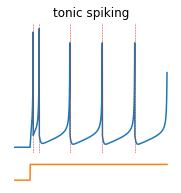

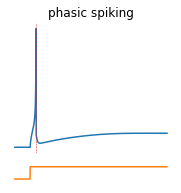

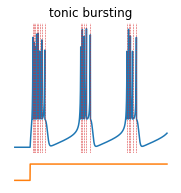

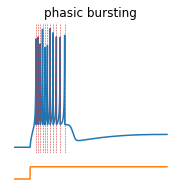

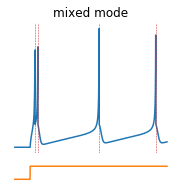

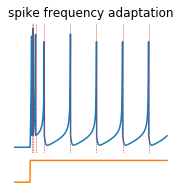

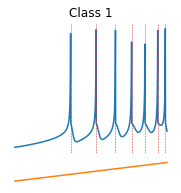

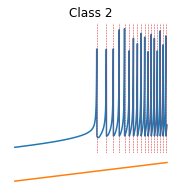

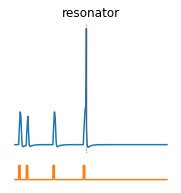

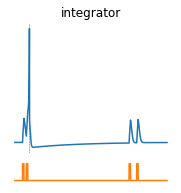

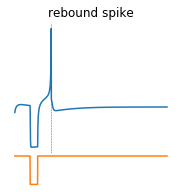

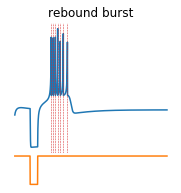

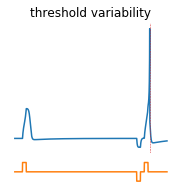

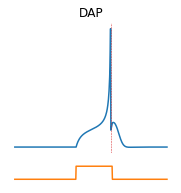

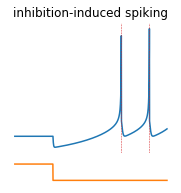

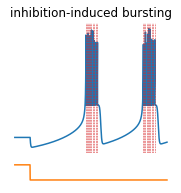

In [16]:
plot_neuro_properties()

### The figure in the Thesis

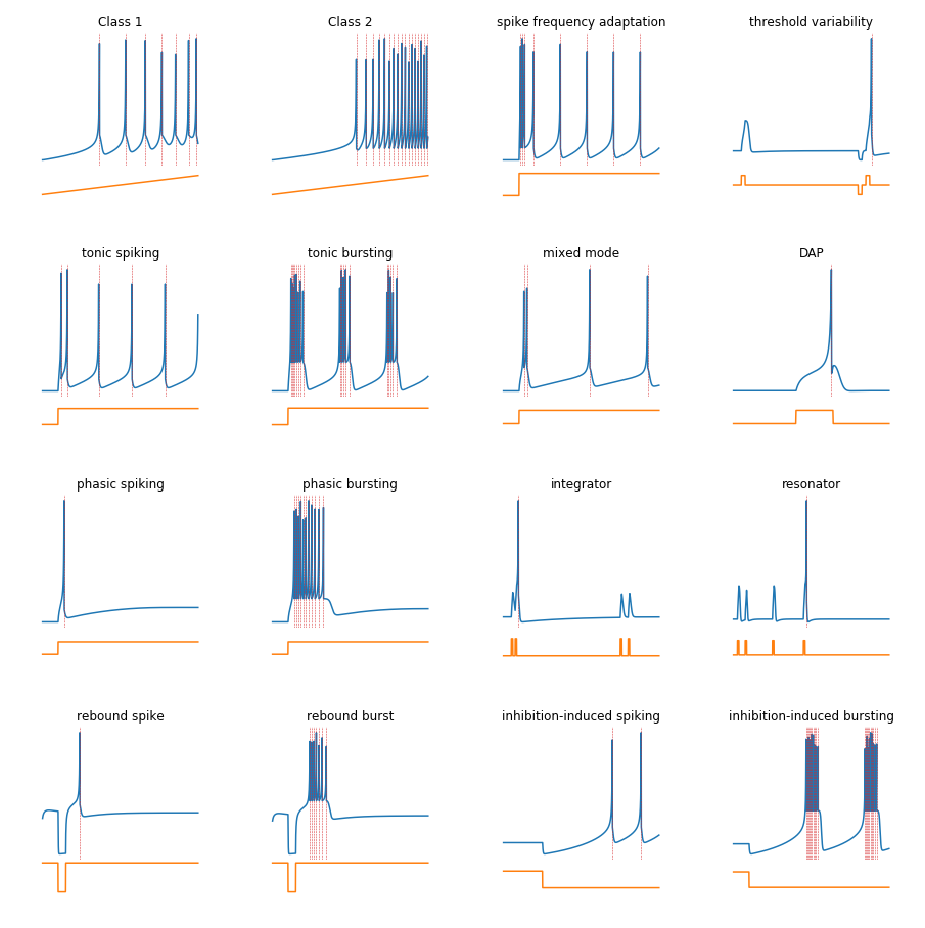

In [249]:
def generate_neuro_properties_figure():
    directory = 'figures/'

    f = open('figures.txt', 'r')

    fig, axs = subplots(4, 4, figsize=(13,13))

    for ax, fig_name in zip(flatten(axs), f.readlines()):
        ax.axis('off')
        ax.imshow(imread(directory+fig_name.strip()))
        
    fig.tight_layout()
    fig.savefig('figures/neuro_properties.png')

generate_neuro_properties_figure()